# Assignment 3: Convolutional Neural Networks with Pytorch

For this assignment, we're going to use one of most popular deep learning frameworks: PyTorch. And build our way through Convolutional Neural Networks.

### What is PyTorch?

PyTorch is a system for executing dynamic computational graphs over Tensor objects that behave similarly as numpy ndarray. It comes with a powerful automatic differentiation engine that removes the need for manual back-propagation. 

### Why?

* Our code will now run on GPUs! Much faster training. When using a framework like PyTorch or TensorFlow you can harness the power of the GPU for your own custom neural network architectures without having to write CUDA code directly (which is beyond the scope of this class).
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry.

### PyTorch versions
This notebook assumes that you are using **PyTorch version >=1.0**. For example, recent `torch==1.13.0` is a good option to go.

**If you are running on datahub, you shouldn't face any problem.**

You can also find the detailed PyTorch [API doc](http://pytorch.org/docs/stable/index.html) here. If you have other questions that are not addressed by the API docs, the [PyTorch forum](https://discuss.pytorch.org/) is a much better place to ask than StackOverflow.


# Table of Contents

This assignment has 6 parts. You will learn PyTorch on **three different levels of abstraction**, which will help you understand it better and prepare you for the final project. 

1. Part I, Preparation: we will use CIFAR-100 dataset.
2. Part II, Barebones PyTorch: **Abstraction level 1**, we will work directly with the lowest-level PyTorch Tensors. 
3. Part III, PyTorch Module API: **Abstraction level 2**, we will use `nn.Module` to define arbitrary neural network architecture. 
4. Part IV, PyTorch Sequential API: **Abstraction level 3**, we will use `nn.Sequential` to define a linear feed-forward network very conveniently.
5. Part V, Resnet10 Implementation: please implement the specific ResNet-10 architecture provided in this assignment and play around with it.
6. Part VI, CIFAR-100 open-ended challenge: please implement your own network to get as high accuracy as possible on CIFAR-100. You can experiment with any layer, optimizer, hyperparameters or other advanced features.

Here is a table of comparison:

| API           | Flexibility | Convenience |
|---------------|-------------|-------------|
| Barebone      | High        | Low         |
| `nn.Module`     | High        | Medium      |
| `nn.Sequential` | Low         | High        |

# Part I. Preparation

First, we load the CIFAR-100 dataset. This might take a couple minutes the first time you do it, but the files should stay cached after that.

In previous parts of the assignment we had to write our own code to download the CIFAR-20 dataset, preprocess it, and iterate through it in minibatches; PyTorch provides convenient tools to automate this process for us.

In [38]:
# Add official website of pytorch

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import torch.nn.functional as F  # useful stateless functions

In [39]:
NUM_TRAIN = 49000
batch_size= 64

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.

#===========================================================================#
# You should try changing the transform for the training data to include    #
# data augmentation such as RandmCrop and HorizontalFlip                    #
# when running the final part of the notebook where you have to achieve     #
# as high accuracy as possible on CIFAR-100.                                #
# Of course you will have to re-run this block for the effect to take place #
#===========================================================================#
train_transform = transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms mini-batches. We divide the CIFAR-100
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar100_train = dset.CIFAR100('./datasets/cifar100', train=True, download=True,
                             transform=train_transform)
loader_train = DataLoader(cifar100_train, batch_size=batch_size, num_workers=2,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar100_val = dset.CIFAR100('./datasets/cifar100', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar100_val, batch_size=batch_size, num_workers=2, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar100_test = dset.CIFAR100('./datasets/cifar100', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar100_test, batch_size=batch_size, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


You have an option to **use GPU by setting the flag to True below**. It is not necessary to use GPU for this assignment. Note that if your computer does not have CUDA enabled, `torch.cuda.is_available()` will return False and this notebook will fallback to CPU mode.
**You can run on GPU on datahub.**

The global variables `dtype` and `device` will control the data types throughout this assignment. 

In [40]:
USE_GPU = True
num_class = 100
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


# Part II. Barebones PyTorch (10% of Grade)

PyTorch ships with high-level APIs to help us define model architectures conveniently, which we will cover in Part II of this tutorial. In this section, we will start with the barebone PyTorch elements to understand the autograd engine better. After this exercise, you will come to appreciate the high-level model API more.

We will start with a simple fully-connected ReLU network with two hidden layers and no biases for CIFAR-100 classification. 
This implementation computes the forward pass using operations on PyTorch Tensors, and uses PyTorch autograd to compute gradients. It is important that you understand every line, because you will write a harder version after the example.

When we create a PyTorch Tensor with `requires_grad=True`, then operations involving that Tensor will not just compute values; they will also build up a computational graph in the background, allowing us to easily backpropagate through the graph to compute gradients of some Tensors with respect to a downstream loss. Concretely if x is a Tensor with `x.requires_grad == True` then after backpropagation `x.grad` will be another Tensor holding the gradient of x with respect to the scalar loss at the end.

### PyTorch Tensors: Flatten Function
A PyTorch Tensor is conceptionally similar to a numpy array: it is an n-dimensional grid of numbers, and like numpy PyTorch provides many functions to efficiently operate on Tensors. As a simple example, we provide a `flatten` function below which reshapes image data for use in a fully-connected neural network.

Recall that image data is typically stored in a Tensor of shape N x C x H x W, where:

* N is the number of datapoints
* C is the number of channels
* H is the height of the intermediate feature map in pixels
* W is the height of the intermediate feature map in pixels

This is the right way to represent the data when we are doing something like a 2D convolution, that needs spatial understanding of where the intermediate features are relative to each other. When we use fully connected affine layers to process the image, however, we want each datapoint to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data. So, we use a "flatten" operation to collapse the `C x H x W` values per representation into a single long vector. The flatten function below first reads in the N, C, H, and W values from a given batch of data, and then returns a "view" of that data. "View" is analogous to numpy's "reshape" method: it reshapes x's dimensions to be N x ??, where ?? is allowed to be anything (in this case, it will be C x H x W, but we don't need to specify that explicitly). 

In [41]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()

Before flattening:  tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening:  tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


### Barebones PyTorch: Two-Layer Network

Here we define a function `two_layer_fc` which performs the forward pass of a two-layer fully-connected ReLU network on a batch of image data. After defining the forward pass we check that it doesn't crash and that it produces outputs of the right shape by running zeros through the network.

You don't have to write any code here, but it's important that you read and understand the implementation.

In [42]:
import torch.nn.functional as F  # useful stateless functions

def two_layer_fc(x, params):
    """
    A fully-connected neural networks; the architecture is:
    NN is fully connected -> ReLU -> fully connected layer.
    Note that this function only defines the forward pass; 
    PyTorch will take care of the backward pass for us.
    
    The input to the network will be a minibatch of data, of shape
    (N, d1, ..., dM) where d1 * ... * dM = D. The hidden layer will have H units,
    and the output layer will produce scores for C classes.
    
    Inputs:
    - x: A PyTorch Tensor of shape (N, d1, ..., dM) giving a minibatch of
      input data.
    - params: A list [w1, w2] of PyTorch Tensors giving weights for the network;
      w1 has shape (D, H) and w2 has shape (H, C).
    
    Returns:
    - scores: A PyTorch Tensor of shape (N, C) giving classification scores for
      the input data x.
    """
    # first we flatten the image
    x = flatten(x)  # shape: [batch_size, C x H x W]
    
    w1, w2 = params
    
    # Forward pass: compute predicted y using operations on Tensors. Since w1 and
    # w2 have requires_grad=True, operations involving these Tensors will cause
    # PyTorch to build a computational graph, allowing automatic computation of
    # gradients. Since we are no longer implementing the backward pass by hand we
    # don't need to keep references to intermediate values.
    # you can also use `.clamp(min=0)`, equivalent to F.relu()
    x = F.relu(x.mm(w1))
    x = x.mm(w2)
    return x
    

def two_layer_fc_test():
    hidden_layer_size = 42
    x = torch.zeros((64, 50), dtype=dtype)  # minibatch size 64, feature dimension 50
    w1 = torch.zeros((50, hidden_layer_size), dtype=dtype)
    w2 = torch.zeros((hidden_layer_size, num_class), dtype=dtype)
    scores = two_layer_fc(x, [w1, w2])
    print(scores.size())  # you should see [64, 100]

two_layer_fc_test()

torch.Size([64, 100])


### Barebones PyTorch: Three-Layer ConvNet

Here you will complete the implementation of the function `three_layer_convnet`, which will perform the forward pass of a three-layer convolutional network. Like above, we can immediately test our implementation by passing zeros through the network. The network should have the following architecture:

1. A convolutional layer (with bias) with `channel_1` filters, each with shape `KW1 x KH1`, and zero-padding of two
2. ReLU nonlinearity
3. A convolutional layer (with bias) with `channel_2` filters, each with shape `KW2 x KH2`, and zero-padding of one
4. ReLU nonlinearity
5. Fully-connected layer with bias, producing scores for C classes.

Note that we have **no softmax activation** here after our fully-connected layer: this is because PyTorch's cross entropy loss performs a softmax activation for you, and by bundling that step in makes computation more efficient.

**HINT**: For convolutions: https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.conv2d; pay attention to the shapes of convolutional filters!

In [43]:
def three_layer_convnet(x, params):
    """
    Performs the forward pass of a three-layer convolutional network with the
    architecture defined above.

    Inputs:
    - x: A PyTorch Tensor of shape (N, 3, H, W) giving a minibatch of images
    - params: A list of PyTorch Tensors giving the weights and biases for the
      network; should contain the following:
      - conv_w1: PyTorch Tensor of shape (channel_1, 3, KH1, KW1) giving weights
        for the first convolutional layer
      - conv_b1: PyTorch Tensor of shape (channel_1,) giving biases for the first
        convolutional layer
      - conv_w2: PyTorch Tensor of shape (channel_2, channel_1, KH2, KW2) giving
        weights for the second convolutional layer
      - conv_b2: PyTorch Tensor of shape (channel_2,) giving biases for the second
        convolutional layer
      - fc_w: PyTorch Tensor giving weights for the fully-connected layer. Can you
        figure out what the shape should be?
      - fc_b: PyTorch Tensor giving biases for the fully-connected layer. Can you
        figure out what the shape should be?
    
    Returns:
    - scores: PyTorch Tensor of shape (N, C) giving classification scores for x
    """
    conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b = params
    scores = None
    ################################################################################
    # TODO: Implement the forward pass for the three-layer ConvNet.                #
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    x = F.conv2d(x, conv_w1, conv_b1, padding = 2)
    x = F.relu(x)
    x = F.conv2d(x, conv_w2, conv_b2, padding = 1)
    x = F.relu(x)
    x = flatten(x)
    scores = F.linear(x, fc_w.T, fc_b)

    # pass

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################
    return scores

After defining the forward pass of the ConvNet above, run the following cell to test your implementation.

When you run this function, scores should have shape (64, 100).

In [44]:
def three_layer_convnet_test():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]

    conv_w1 = torch.zeros((6, 3, 5, 5), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b1 = torch.zeros((6,))  # out_channel
    conv_w2 = torch.zeros((9, 6, 3, 3), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b2 = torch.zeros((9,))  # out_channel

    # you must calculate the shape of the tensor after two conv layers, before the fully-connected layer
    fc_w = torch.zeros((9 * 32 * 32, num_class))
    fc_b = torch.zeros(num_class)

    scores = three_layer_convnet(x, [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b])
    print(scores.size())  # you should see [64, 100]
three_layer_convnet_test()

torch.Size([64, 100])


### Barebones PyTorch: Initialization
Let's write a couple utility methods to initialize the weight matrices for our models.

- `random_weight(shape)` initializes a weight tensor with the Kaiming normalization method.
- `zero_weight(shape)` initializes a weight tensor with all zeros. Useful for instantiating bias parameters.

The `random_weight` function uses the Kaiming normal initialization method, described in:

He et al, *Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification*, ICCV 2015, https://arxiv.org/abs/1502.01852

In [45]:
def random_weight(shape):
    """
    Create random Tensors for weights; setting requires_grad=True means that we
    want to compute gradients for these Tensors during the backward pass.
    We use Kaiming normalization: sqrt(2 / fan_in)
    """
    if len(shape) == 2:  # FC weight
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW]
    # randn is standard normal distribution generator. 
    w = torch.randn(shape, device=device, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

def zero_weight(shape):
    return torch.zeros(shape, device=device, dtype=dtype, requires_grad=True)

# create a weight of shape [3 x 5]
# you should see the type `torch.cuda.FloatTensor` if you use GPU. 
# Otherwise it should be `torch.FloatTensor`
random_weight((3, 5))

tensor([[ 9.3276e-01, -1.2819e+00,  7.3860e-01, -3.3356e-01, -1.1516e-01],
        [ 1.3274e+00,  2.0682e+00, -1.5737e+00, -2.4215e-01,  2.2095e-01],
        [ 7.2762e-04, -9.3259e-01,  4.6256e-01,  1.1160e+00,  7.8059e-01]],
       device='cuda:0', requires_grad=True)

### Barebones PyTorch: Check Accuracy
When training the model we will use the following function to check the accuracy of our model on the training or validation sets.

When checking accuracy we don't need to compute any gradients; as a result we don't need PyTorch to build a computational graph for us when we compute scores. To prevent a graph from being built we scope our computation under a `torch.no_grad()` context manager.

In [46]:
def check_accuracy_part2(loader, model_fn, params):
    """
    Check the accuracy of a classification model.
    
    Inputs:
    - loader: A DataLoader for the data split we want to check
    - model_fn: A function that performs the forward pass of the model,
      with the signature scores = model_fn(x, params)
    - params: List of PyTorch Tensors giving parameters of the model
    
    Returns: Nothing, but prints the accuracy of the model
    """
    split = 'val' if loader.dataset.train else 'test'
    print('Checking accuracy on the %s set' % split)
    num_correct, num_samples = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.int64)
            scores = model_fn(x, params)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

### BareBones PyTorch: Training Loop
We can now set up a basic training loop to train our network. We will train the model using stochastic gradient descent without momentum. We will use `torch.functional.cross_entropy` to compute the loss; you can [read about it here](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.cross_entropy).

The training loop takes as input the neural network function, a list of initialized parameters (`[w1, w2]` in our example), and learning rate.

In [47]:
def train_part2(model_fn, params, learning_rate):
    """
    Train a model on CIFAR-10.
    
    Inputs:
    - model_fn: A Python function that performs the forward pass of the model.
      It should have the signature scores = model_fn(x, params) where x is a
      PyTorch Tensor of image data, params is a list of PyTorch Tensors giving
      model weights, and scores is a PyTorch Tensor of shape (N, C) giving
      scores for the elements in x.
    - params: List of PyTorch Tensors giving weights for the model
    - learning_rate: Python scalar giving the learning rate to use for SGD
    
    Returns: Nothing
    """
    for t, (x, y) in enumerate(loader_train):
        # Move the data to the proper device (GPU or CPU)
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)

        # Forward pass: compute scores and loss
        scores = model_fn(x, params)
        loss = F.cross_entropy(scores, y)

        # Backward pass: PyTorch figures out which Tensors in the computational
        # graph has requires_grad=True and uses backpropagation to compute the
        # gradient of the loss with respect to these Tensors, and stores the
        # gradients in the .grad attribute of each Tensor.
        loss.backward()

        # Update parameters. We don't want to backpropagate through the
        # parameter updates, so we scope the updates under a torch.no_grad()
        # context manager to prevent a computational graph from being built.
        with torch.no_grad():
            for w in params:
                w -= learning_rate * w.grad

                # Manually zero the gradients after running the backward pass
                w.grad.zero_()

        if t % print_every == 0:
            print('Iteration %d, loss = %.4f' % (t, loss.item()))
            check_accuracy_part2(loader_val, model_fn, params)
            print()

### BareBones PyTorch: Train a Two-Layer Network
Now we are ready to run the training loop. We need to explicitly allocate tensors for the fully connected weights, `w1` and `w2`. 

Each minibatch of CIFAR has 64 examples, so the tensor shape is `[64, 3, 32, 32]`. 

After flattening, `x` shape should be `[64, 3 * 32 * 32]`. This will be the size of the first dimension of `w1`. 
The second dimension of `w1` is the hidden layer size, which will also be the first dimension of `w2`. 

Finally, the output of the network is a 100-dimensional vector that represents the probability distribution over 100 classes. 

You don't need to tune any hyperparameters, but you should see accuracies around 10% after training for one epoch.

In [48]:
hidden_layer_size = 4000
learning_rate = 1e-2

w1 = random_weight((3 * 32 * 32, hidden_layer_size))
w2 = random_weight((hidden_layer_size, num_class))

train_part2(two_layer_fc, [w1, w2], learning_rate)

Iteration 0, loss = 5.4983
Checking accuracy on the val set
Got 7 / 1000 correct (0.70%)

Iteration 100, loss = 4.0326
Checking accuracy on the val set
Got 81 / 1000 correct (8.10%)

Iteration 200, loss = 4.1044
Checking accuracy on the val set
Got 112 / 1000 correct (11.20%)

Iteration 300, loss = 3.8314
Checking accuracy on the val set
Got 130 / 1000 correct (13.00%)

Iteration 400, loss = 3.3887
Checking accuracy on the val set
Got 140 / 1000 correct (14.00%)

Iteration 500, loss = 4.0037
Checking accuracy on the val set
Got 158 / 1000 correct (15.80%)

Iteration 600, loss = 3.7727
Checking accuracy on the val set
Got 149 / 1000 correct (14.90%)

Iteration 700, loss = 3.5578
Checking accuracy on the val set
Got 162 / 1000 correct (16.20%)



### BareBones PyTorch: Training a ConvNet

In the below cell you should use the functions defined above to train a three-layer convolutional network on CIFAR. The network should have the following architecture:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 100 classes

You should initialize your weight matrices using the `random_weight` function defined above, and you should initialize your bias vectors using the `zero_weight` function above.

You don't need to tune any hyperparameters, but you should see accuracies around 10% after training for one epoch.


In [49]:
learning_rate = 3e-3

channel_1 = 32
channel_2 = 16

conv_w1 = None
conv_b1 = None
conv_w2 = None
conv_b2 = None
fc_w = None
fc_b = None

################################################################################
# TODO: Initialize the parameters of a three-layer ConvNet.                    #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
conv_w1 = random_weight((channel_1, 3, 5, 5))
conv_b1 = zero_weight((channel_1, ))
conv_w2 = random_weight((channel_2, channel_1, 3, 3))
conv_b2 = zero_weight((channel_2, ))
fc_w = random_weight((channel_2 * 32 * 32, 100))
fc_b = zero_weight((100))
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]
train_part2(three_layer_convnet, params, learning_rate)

Iteration 0, loss = 5.2357
Checking accuracy on the val set
Got 14 / 1000 correct (1.40%)

Iteration 100, loss = 4.4008
Checking accuracy on the val set
Got 61 / 1000 correct (6.10%)

Iteration 200, loss = 4.1271
Checking accuracy on the val set
Got 80 / 1000 correct (8.00%)

Iteration 300, loss = 3.9451
Checking accuracy on the val set
Got 106 / 1000 correct (10.60%)

Iteration 400, loss = 3.9508
Checking accuracy on the val set
Got 117 / 1000 correct (11.70%)

Iteration 500, loss = 3.8913
Checking accuracy on the val set
Got 122 / 1000 correct (12.20%)

Iteration 600, loss = 3.6922
Checking accuracy on the val set
Got 141 / 1000 correct (14.10%)

Iteration 700, loss = 3.6848
Checking accuracy on the val set
Got 140 / 1000 correct (14.00%)



# Part III. PyTorch Module API (10% of Grade)

Barebone PyTorch requires that we track all the parameter tensors by hand. This is fine for small networks with a few tensors, but it would be extremely inconvenient and error-prone to track tens or hundreds of tensors in larger networks.

PyTorch provides the `nn.Module` API for you to define arbitrary network architectures, while tracking every learnable parameters for you. In Part II, we implemented SGD ourselves. PyTorch also provides the `torch.optim` package that implements all the common optimizers, such as RMSProp, Adagrad, and Adam. It even supports approximate second-order methods like L-BFGS! You can refer to the [doc](http://pytorch.org/docs/master/optim.html) for the exact specifications of each optimizer.

To use the Module API, follow the steps below:

1. Subclass `nn.Module`. Give your network class an intuitive name like `TwoLayerFC`. 

2. In the constructor `__init__()`, define all the layers you need as class attributes. Layer objects like `nn.Linear` and `nn.Conv2d` are themselves `nn.Module` subclasses and contain learnable parameters, so that you don't have to instantiate the raw tensors yourself. `nn.Module` will track these internal parameters for you. Refer to the [doc](http://pytorch.org/docs/master/nn.html) to learn more about the dozens of builtin layers. **Warning**: don't forget to call the `super().__init__()` first!

3. In the `forward()` method, define the *connectivity* of your network. You should use the attributes defined in `__init__` as function calls that take tensor as input and output the "transformed" tensor. Do *not* create any new layers with learnable parameters in `forward()`! All of them must be declared upfront in `__init__`. 

After you define your Module subclass, you can instantiate it as an object and call it just like the NN forward function in part II.

### Module API: Two-Layer Network
Here is a concrete example of a 2-layer fully connected network:

In [50]:
class TwoLayerFC(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        # assign layer objects to class attributes
        self.fc1 = nn.Linear(input_size, hidden_size)
        # nn.init package contains convenient initialization methods
        # http://pytorch.org/docs/master/nn.html#torch-nn-init 
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        nn.init.kaiming_normal_(self.fc2.weight)
    
    def forward(self, x):
        # forward always defines connectivity
        x = flatten(x)
        scores = self.fc2(F.relu(self.fc1(x)))
        return scores

def test_TwoLayerFC():
    input_size = 50
    x = torch.zeros((64, input_size), dtype=dtype)  # minibatch size 64, feature dimension 50
    model = TwoLayerFC(input_size, 42, num_class)
    scores = model(x)
    print(scores.size())  # you should see [64, 100]
test_TwoLayerFC()

torch.Size([64, 100])


### Module API: Three-Layer ConvNet
It's your turn to implement a 3-layer ConvNet followed by a fully connected layer. The network architecture should be the same as in Part II:

1. Convolutional layer with `channel_1` 5x5 filters with zero-padding of 2
2. ReLU
3. Convolutional layer with `channel_2` 3x3 filters with zero-padding of 1
4. ReLU
5. Fully-connected layer to `num_classes` classes

You should initialize the weight matrices of the model using the Kaiming normal initialization method.

**HINT**: http://pytorch.org/docs/stable/nn.html#conv2d

After you implement the three-layer ConvNet, the `test_ThreeLayerConvNet` function will run your implementation; it should print `(64, 100)` for the shape of the output scores.

In [51]:
class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()
      
        self.conv_1 = nn.Conv2d(in_channel, channel_1, (5,5), padding=2)
        nn.init.kaiming_normal_(self.conv_1.weight)
        self.conv_2 = nn.Conv2d(channel_1, channel_2, (3,3), padding=1)
        nn.init.kaiming_normal_(self.conv_2.weight)

        self.fc1 = nn.Linear(65536, num_classes)
        self.relu = nn.ReLU(inplace=True)
        


    def forward(self, x):
        scores = None
        ########################################################################
        # TODO: Implement the forward function for a 3-layer ConvNet. you      #
        # should use the layers you defined in __init__ and specify the        #
        # connectivity of those layers in forward()                            #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = flatten(x)
        scores = self.fc1(x)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return scores


def test_ThreeLayerConvNet():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]
    model = ThreeLayerConvNet(in_channel=3, channel_1=32, channel_2=64, num_classes=num_class)
    scores = model(x)
    print(scores.size())  # you should see [64, 100]
test_ThreeLayerConvNet()

torch.Size([64, 100])


### Module API: Check Accuracy
Given the validation or test set, we can check the classification accuracy of a neural network. 

This version is slightly different from the one in part II. You don't manually pass in the parameters anymore.

In [52]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc

### Module API: Training Loop
We also use a slightly different training loop. Rather than updating the values of the weights ourselves, we use an Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

In [53]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    val_acc = []
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            
            if t % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                acc = check_accuracy_part34(loader_val, model)
                val_acc.append(acc)
                print()
    try:
        return val_acc
    except:
        pass

### Module API: Train a Two-Layer Network
Now we are ready to run the training loop. In contrast to part II, we don't explicitly allocate parameter tensors anymore.

Simply pass the input size, hidden layer size, and number of classes (i.e. output size) to the constructor of `TwoLayerFC`. 

You also need to define an optimizer that tracks all the learnable parameters inside `TwoLayerFC`.

You don't need to tune any hyperparameters, but you should see model accuracies increasing during the training.

In [54]:
hidden_layer_size = 4000
learning_rate = 1e-3
model = TwoLayerFC(3 * 32 * 32, hidden_layer_size, num_class)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

_ = train_part34(model, optimizer)
pass

Epoch 0, Iteration 0, loss = 5.6466
Checking accuracy on validation set
Got 13 / 1000 correct (1.30)

Epoch 0, Iteration 100, loss = 4.9048
Checking accuracy on validation set
Got 33 / 1000 correct (3.30)

Epoch 0, Iteration 200, loss = 4.5089
Checking accuracy on validation set
Got 39 / 1000 correct (3.90)

Epoch 0, Iteration 300, loss = 4.1385
Checking accuracy on validation set
Got 48 / 1000 correct (4.80)

Epoch 0, Iteration 400, loss = 4.3048
Checking accuracy on validation set
Got 68 / 1000 correct (6.80)

Epoch 0, Iteration 500, loss = 4.2920
Checking accuracy on validation set
Got 75 / 1000 correct (7.50)

Epoch 0, Iteration 600, loss = 4.0859
Checking accuracy on validation set
Got 82 / 1000 correct (8.20)

Epoch 0, Iteration 700, loss = 4.0621
Checking accuracy on validation set
Got 88 / 1000 correct (8.80)



### Module API: Train a Three-Layer ConvNet
You should now use the Module API to train a three-layer ConvNet on CIFAR. This should look very similar to training the two-layer network!

You don't need to tune any hyperparameters, but you should achieve better accuracy than the previous Two-Layer Network.

You should train the model using stochastic gradient descent without momentum.

In [55]:
learning_rate = 1e-3
channel_1 = 32
channel_2 = 64

model = None
optimizer = None
################################################################################
# TODO: Instantiate your ThreeLayerConvNet model and a corresponding optimizer #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
model = ThreeLayerConvNet(in_channel = 3, channel_1 = channel_1, channel_2 = channel_2, num_classes = 100)
optimizer = optim.SGD(model.parameters(), lr = learning_rate)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

_ = train_part34(model, optimizer, epochs=1)
pass

Epoch 0, Iteration 0, loss = 4.5731
Checking accuracy on validation set
Got 12 / 1000 correct (1.20)

Epoch 0, Iteration 100, loss = 4.1910
Checking accuracy on validation set
Got 89 / 1000 correct (8.90)

Epoch 0, Iteration 200, loss = 4.3726
Checking accuracy on validation set
Got 120 / 1000 correct (12.00)

Epoch 0, Iteration 300, loss = 3.6250
Checking accuracy on validation set
Got 129 / 1000 correct (12.90)

Epoch 0, Iteration 400, loss = 3.7189
Checking accuracy on validation set
Got 153 / 1000 correct (15.30)

Epoch 0, Iteration 500, loss = 3.8522
Checking accuracy on validation set
Got 147 / 1000 correct (14.70)

Epoch 0, Iteration 600, loss = 3.5486
Checking accuracy on validation set
Got 153 / 1000 correct (15.30)

Epoch 0, Iteration 700, loss = 3.7248
Checking accuracy on validation set
Got 177 / 1000 correct (17.70)



# Part IV. PyTorch Sequential API (10% of Grade)

Part III introduced the PyTorch Module API, which allows you to define arbitrary learnable layers and their connectivity. 

For simple models like a stack of feed forward layers, you still need to go through 3 steps: subclass `nn.Module`, assign layers to class attributes in `__init__`, and call each layer one by one in `forward()`. Is there a more convenient way? 

Fortunately, PyTorch provides a container Module called `nn.Sequential`, which merges the above steps into one. It is not as flexible as `nn.Module`, because you cannot specify more complex topology than a feed-forward stack, but it's good enough for many use cases.

### Sequential API: Two-Layer Network
Let's see how to rewrite our two-layer fully connected network example with `nn.Sequential`, and train it using the training loop defined above.

Again, You don't need to tune any hyperparameters, but you should see accuracies above 10% after training for one epoch.


In [56]:
# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

hidden_layer_size = 4000
learning_rate = 1e-2

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, num_class),
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

_ = train_part34(model, optimizer)
pass

Epoch 0, Iteration 0, loss = 4.6676
Checking accuracy on validation set
Got 14 / 1000 correct (1.40)

Epoch 0, Iteration 100, loss = 3.6489
Checking accuracy on validation set
Got 116 / 1000 correct (11.60)

Epoch 0, Iteration 200, loss = 3.9093
Checking accuracy on validation set
Got 137 / 1000 correct (13.70)

Epoch 0, Iteration 300, loss = 3.6542
Checking accuracy on validation set
Got 138 / 1000 correct (13.80)

Epoch 0, Iteration 400, loss = 3.1449
Checking accuracy on validation set
Got 172 / 1000 correct (17.20)

Epoch 0, Iteration 500, loss = 3.7378
Checking accuracy on validation set
Got 143 / 1000 correct (14.30)

Epoch 0, Iteration 600, loss = 3.4116
Checking accuracy on validation set
Got 160 / 1000 correct (16.00)

Epoch 0, Iteration 700, loss = 3.3471
Checking accuracy on validation set
Got 159 / 1000 correct (15.90)



### Sequential API: Three-Layer ConvNet
Here you should use `nn.Sequential` to define and train a three-layer ConvNet with the same architecture we used in Part III:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 100 classes

You should initialize your weight matrices using the `random_weight` function defined above, and you should initialize your bias vectors using the `zero_weight` function above.

You should optimize your model using stochastic gradient descent with Nesterov momentum 0.9.

Again, You don't need to tune any hyperparameters, but you should see accuracies above 12% after training for one epoch.



In [57]:
channel_1 = 32
channel_2 = 16
learning_rate = 1e-3

model = None
optimizer = None

################################################################################
# TODO: Rewrite the 2-layer ConvNet with bias from Part III with the           #
# Sequential API.                                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
model = nn.Sequential(
    nn.Conv2d(3, channel_1, (5, 5), padding = 2),
    nn.ReLU(inplace=True),
    nn.Conv2d(channel_1, channel_2, (3,3), padding = 1),
    nn.ReLU(inplace = True),
    Flatten(),
    nn.Linear(channel_2 * 32 * 32, 100)
)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

train_part34(model, optimizer, epochs=1)
pass

Epoch 0, Iteration 0, loss = 4.6004
Checking accuracy on validation set
Got 13 / 1000 correct (1.30)

Epoch 0, Iteration 100, loss = 4.4509
Checking accuracy on validation set
Got 67 / 1000 correct (6.70)

Epoch 0, Iteration 200, loss = 3.7488
Checking accuracy on validation set
Got 105 / 1000 correct (10.50)

Epoch 0, Iteration 300, loss = 3.8743
Checking accuracy on validation set
Got 126 / 1000 correct (12.60)

Epoch 0, Iteration 400, loss = 3.7277
Checking accuracy on validation set
Got 129 / 1000 correct (12.90)

Epoch 0, Iteration 500, loss = 3.8099
Checking accuracy on validation set
Got 157 / 1000 correct (15.70)

Epoch 0, Iteration 600, loss = 3.5819
Checking accuracy on validation set
Got 162 / 1000 correct (16.20)

Epoch 0, Iteration 700, loss = 3.7548
Checking accuracy on validation set
Got 165 / 1000 correct (16.50)



# Part V. Resnet10 Implementation (35% of Grade)

In this section, you will use the tools introduced above to implement the Resnet architecture. The Resnet architecture was introduced in: https://arxiv.org/pdf/1512.03385.pdf and it has become one of the most popular architectures used for computer vision. The key feature of the resnet architecture is the presence of skip connections which allow for better gradient flow even for very deep networks. Therefore, unlike vanilla CNNs introduced above, we can effectively build Resnets models having more than 100 layers. However, for the purposes of this exercise we will be using a smaller Resnet-10 architecture shown in the diagram below:

![model.png](model.png)

In the architecture above, the down-sampling is performed in conv5_1. We recommend using the adam optimizer for training Resnet. You should see about *45%* accuracy in 10 epochs. The template below is based on the Module API, but you are allowed to use other Pytorch APIs if you prefer.
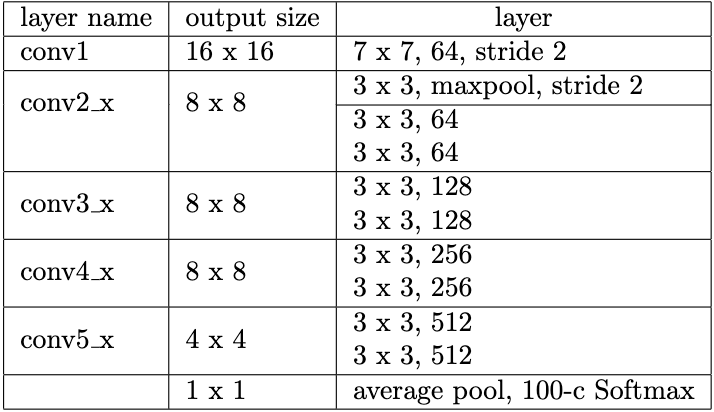

In [58]:
########################################################################
# TODO: Implement the forward function for the Resnet specified        #
# above. HINT: You might need to create a helper class to              # 
# define a Resnet block and then use that block here to create         #
# the resnet layers i.e. conv2_x, conv3_x, conv4_x and conv5_x         #
########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

def conv(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), 
                    stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.bn = bn
        self.conv1 = conv(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        if self.bn:
            out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        if self.bn:
            out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, bn, num_classes=100):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.bn = bn
        self.conv = nn.Conv2d(3, 64, kernel_size=(7, 7), stride = 2, padding = 3, bias = False)
        self.relu = nn.ReLU(inplace=True)
        self.bns = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d((3, 3), stride=2, padding=1)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1])
        self.layer3 = self.make_layer(block, 256, layers[2])
        self.layer4 = self.make_layer(block, 512, layers[3], 2)
        self.avg_pool = nn.AvgPool2d((4, 4), stride=1)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if ((stride != 1) or (self.in_channels != out_channels)):
            if not self.bn:
                downsample = nn.Sequential(
                    nn.Conv2d(self.in_channels, out_channels, kernel_size=(1, 1), stride=stride))
            else :
                downsample = nn.Sequential(
                    nn.Conv2d(self.in_channels, out_channels, kernel_size=(1, 1), stride=stride),
                    nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, self.bn, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels, self.bn))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        if self.bn :
            out = self.bns(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

########################################################################
#                             END OF YOUR CODE                         #
########################################################################

In [59]:
learning_rate = 1e-3

model = None
optimizer = None

################################################################################
# TODO: Instantiate and train Resnet-10.                                       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
model = ResNet(ResidualBlock, [2, 2, 2, 2], False).to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

train_part34(model, optimizer, epochs=10)
pass

Epoch 0, Iteration 0, loss = 4.6082
Checking accuracy on validation set
Got 9 / 1000 correct (0.90)

Epoch 0, Iteration 100, loss = 4.4698
Checking accuracy on validation set
Got 12 / 1000 correct (1.20)

Epoch 0, Iteration 200, loss = 4.2151
Checking accuracy on validation set
Got 31 / 1000 correct (3.10)

Epoch 0, Iteration 300, loss = 4.0490
Checking accuracy on validation set
Got 36 / 1000 correct (3.60)

Epoch 0, Iteration 400, loss = 3.6735
Checking accuracy on validation set
Got 63 / 1000 correct (6.30)

Epoch 0, Iteration 500, loss = 3.8441
Checking accuracy on validation set
Got 73 / 1000 correct (7.30)

Epoch 0, Iteration 600, loss = 3.8658
Checking accuracy on validation set
Got 92 / 1000 correct (9.20)

Epoch 0, Iteration 700, loss = 3.7942
Checking accuracy on validation set
Got 120 / 1000 correct (12.00)

Epoch 1, Iteration 0, loss = 3.7085
Checking accuracy on validation set
Got 117 / 1000 correct (11.70)

Epoch 1, Iteration 100, loss = 3.4198
Checking accuracy on valida

## BatchNorm

Now you will also introduce the Batch-Normalization layer within the Resnet architecture implemented above. Please add a batch normalization layer after each conv in your network before applying the activation function (i.e. the order should be conv->BatchNorm->Relu). Please read the section 3.4 from the Resnet paper (https://arxiv.org/pdf/1512.03385.pdf. 

Feel free to re-use the Resnet class that you have implemented above by introducing a boolean flag for batch normalization. 

After trying out batch-norm, please discuss the performance comparison between Resnet with BatchNorm and without BatchNorm and possible reasons for why one performs better than the other. 

In [60]:
learning_rate = 1e-3

model = None
optimizer = None

################################################################################
# TODO: InstantiateResnet with BatchNorm                                       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
model = ResNet(ResidualBlock, [2, 2, 2, 2], True).to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

train_part34(model, optimizer, epochs=10)
pass

Epoch 0, Iteration 0, loss = 4.7903
Checking accuracy on validation set
Got 12 / 1000 correct (1.20)

Epoch 0, Iteration 100, loss = 3.9553
Checking accuracy on validation set
Got 53 / 1000 correct (5.30)

Epoch 0, Iteration 200, loss = 3.9664
Checking accuracy on validation set
Got 102 / 1000 correct (10.20)

Epoch 0, Iteration 300, loss = 3.5355
Checking accuracy on validation set
Got 102 / 1000 correct (10.20)

Epoch 0, Iteration 400, loss = 3.6076
Checking accuracy on validation set
Got 149 / 1000 correct (14.90)

Epoch 0, Iteration 500, loss = 3.4413
Checking accuracy on validation set
Got 141 / 1000 correct (14.10)

Epoch 0, Iteration 600, loss = 3.1364
Checking accuracy on validation set
Got 174 / 1000 correct (17.40)

Epoch 0, Iteration 700, loss = 3.4349
Checking accuracy on validation set
Got 202 / 1000 correct (20.20)

Epoch 1, Iteration 0, loss = 3.3035
Checking accuracy on validation set
Got 199 / 1000 correct (19.90)

Epoch 1, Iteration 100, loss = 3.1926
Checking accurac

## Discussion on BatchNorm
### TODO: The batchnorm was capable of increasing the accuracy of the validation set up to 10%, which is a significant increase from the maximum of 40% without batchnorm. I believe this to be the case as batch normalization

## Batch Size

In this exercise, we will study the effect of batch size on performance of Resnet. Specifically, you should try batch sizes of 32, 64 and 128 and describe the effect of varying batch size. You should also draw a graph showing the batch size on the x-axis and accuracy on the y-axis.

In [31]:
batch_sizes = [32, 64, 128]
learning_rate = 1e-3
model = None
optimizer = None
import matplotlib.pyplot as plt

################################################################################
# TODO: Try Resnet with different batch sizes. Hint: You will need to          #
#  create a new dataloader with appropriate batch size for each experiment.    #
# You will also need to store the final accuracy for each experiment           # 
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
out = []
for batch in batch_sizes :
    del loader_train
    del loader_val
    del loader_test
    del model
    del optimizer
    loader_train = DataLoader(cifar100_train, batch_size=batch, num_workers=2,
                            sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
    loader_val = DataLoader(cifar100_val, batch_size=batch, num_workers=2, 
                            sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
    loader_test = DataLoader(cifar100_test, batch_size=batch, num_workers=2)

    model = ResNet(ResidualBlock, [2, 2, 2, 2], True).to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    val_accs = train_part34(model, optimizer, epochs=10)
    out.append(val_accs)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

Epoch 0, Iteration 0, loss = 4.7159
Checking accuracy on validation set
Got 13 / 1000 correct (1.30)

Epoch 0, Iteration 100, loss = 4.3172
Checking accuracy on validation set
Got 34 / 1000 correct (3.40)

Epoch 0, Iteration 200, loss = 4.0021
Checking accuracy on validation set
Got 64 / 1000 correct (6.40)

Epoch 0, Iteration 300, loss = 3.7120
Checking accuracy on validation set
Got 64 / 1000 correct (6.40)

Epoch 0, Iteration 400, loss = 3.6175
Checking accuracy on validation set
Got 64 / 1000 correct (6.40)

Epoch 0, Iteration 500, loss = 3.7986
Checking accuracy on validation set
Got 80 / 1000 correct (8.00)

Epoch 0, Iteration 600, loss = 4.0985
Checking accuracy on validation set
Got 102 / 1000 correct (10.20)

Epoch 0, Iteration 700, loss = 3.6939
Checking accuracy on validation set
Got 101 / 1000 correct (10.10)

Epoch 0, Iteration 800, loss = 3.7222
Checking accuracy on validation set
Got 98 / 1000 correct (9.80)

Epoch 0, Iteration 900, loss = 3.3975
Checking accuracy on val

In [61]:
for i, acc in enumerate(out) :
    # print(acc)
    plt.figure(figsize=(10,5))
    plt.title("Validation Acc for Batch Size: " + str(batch_sizes[i]))
    plt.plot(acc,label="val")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

NameError: name 'out' is not defined

## Discuss effect of Batch Size
### TODO: Write your answer here

# Part VI. CIFAR-100 open-ended challenge (25% of Grade)

In this section, you can experiment with whatever ConvNet architecture you'd like on CIFAR-100 **except Resnet** because we already tried it. 

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves **at least 50%** accuracy on the CIFAR-100 **validation** set within 10 epochs. You can use the check_accuracy and train functions from above. You can use either `nn.Module` or `nn.Sequential` API.

Describe what you did at the end of this notebook.

Here are the official API documentation for each component.

* Layers in torch.nn package: http://pytorch.org/docs/stable/nn.html
* Activations: http://pytorch.org/docs/stable/nn.html#non-linear-activations
* Loss functions: http://pytorch.org/docs/stable/nn.html#loss-functions
* Optimizers: http://pytorch.org/docs/stable/optim.html


### Things you might try:
- **Filter size**: Above we used 5x5; would smaller filters be more efficient?
- **Adam Optimizer**: Above we used SGD optimizer, would an Adam optimizer do better?
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster? You can also try out LayerNorm and GroupNorm.
- **Network architecture**: Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use Dropout.

### Tips for training
For each network architecture that you try, you should tune the learning rate and other hyperparameters. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and save your test set for evaluating your architecture on the best parameters as selected by the validation set.

### Want more improvements?
There are many other features you can implement to try and improve your performance.

- Alternative optimizers: you can try Adam, Adagrad, RMSprop, etc.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.

### Have fun and may the gradients be with you! 

In [1]:
# Add official website of pytorch

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import torch.nn.functional as F  # useful stateless functions

NUM_TRAIN = 49000
batch_size= 64

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.

#===========================================================================#
# You should try changing the transform for the training data to include    #
# data augmentation such as RandmCrop and HorizontalFlip                    #
# when running the final part of the notebook where you have to achieve     #
# as high accuracy as possible on CIFAR-100.                                #
# Of course you will have to re-run this block for the effect to take place #
#===========================================================================#
train_transform = transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms mini-batches. We divide the CIFAR-100
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar100_train = dset.CIFAR100('./datasets/cifar100', train=True, download=True,
                             transform=train_transform)
loader_train = DataLoader(cifar100_train, batch_size=batch_size, num_workers=2,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar100_val = dset.CIFAR100('./datasets/cifar100', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar100_val, batch_size=batch_size, num_workers=2, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar100_test = dset.CIFAR100('./datasets/cifar100', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar100_test, batch_size=batch_size, num_workers=2)

USE_GPU = True
num_class = 100
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

import torch.nn.functional as F  # useful stateless functions

def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc

def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    val_acc = []
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            
            if t % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                acc = check_accuracy_part34(loader_val, model)
                val_acc.append(acc)
                print()
    try:
        return val_acc, model
    except:
        pass

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
using device: cuda


In [3]:
class Inception(nn.Module):
    def __init__(self, input_channels, n1x1, n3x3_reduce, n3x3, n5x5_reduce, n5x5, pool_proj):
        super().__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(input_channels, n1x1, kernel_size=(1, 1)),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(inplace=True)
        )

        self.b2 = nn.Sequential(
            nn.Conv2d(input_channels, n3x3_reduce, kernel_size=(1, 1)),
            nn.BatchNorm2d(n3x3_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(n3x3_reduce, n3x3, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(inplace=True)
        )

        self.b3 = nn.Sequential(
            nn.Conv2d(input_channels, n5x5_reduce, kernel_size=(1, 1)),
            nn.BatchNorm2d(n5x5_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5_reduce, n5x5, kernel_size=(5, 5), padding=2),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(inplace=True)
        )

        self.b4 = nn.Sequential(
            nn.MaxPool2d((3, 3), stride=1, padding=1),
            nn.Conv2d(input_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return torch.cat([self.b1(x), self.b2(x), self.b3(x), self.b4(x)], dim=1)


class GoogLeNet(nn.Module):

    def __init__(self, num_class=100):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
        )

        self.a3 = Inception(192, 64, 96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.mp = nn.MaxPool2d((3, 3), stride=2, padding=1)

        self.a4 = Inception(480, 192, 96, 208, 16, 48, 64)
        self.b4 = Inception(512, 160, 112, 224, 24, 64, 64)
        self.c4 = Inception(512, 128, 128, 256, 24, 64, 64)
        self.d4 = Inception(512, 112, 144, 288, 32, 64, 64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.ap = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout2d(p=0.4)
        self.fc = nn.Linear(1024, num_class)

    def forward(self, x):
        x = self.layer(x)

        x = self.mp(x)

        x = self.a3(x)
        x = self.b3(x)

        x = self.mp(x)

        x = self.a4(x)
        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)

        x = self.mp(x)

        x = self.a5(x)
        x = self.b5(x)

        x = self.ap(x)
        x = self.dropout(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)

        return x

Epoch 0, Iteration 0, loss = 4.6668
Checking accuracy on validation set
Got 14 / 1000 correct (1.40)

Epoch 0, Iteration 100, loss = 3.9326
Checking accuracy on validation set
Got 46 / 1000 correct (4.60)

Epoch 0, Iteration 200, loss = 3.8612
Checking accuracy on validation set
Got 63 / 1000 correct (6.30)

Epoch 0, Iteration 300, loss = 3.8817
Checking accuracy on validation set
Got 69 / 1000 correct (6.90)

Epoch 0, Iteration 400, loss = 3.5158
Checking accuracy on validation set
Got 129 / 1000 correct (12.90)

Epoch 0, Iteration 500, loss = 3.8531
Checking accuracy on validation set
Got 125 / 1000 correct (12.50)

Epoch 0, Iteration 600, loss = 3.5194
Checking accuracy on validation set
Got 134 / 1000 correct (13.40)

Epoch 0, Iteration 700, loss = 3.8175
Checking accuracy on validation set
Got 145 / 1000 correct (14.50)

Epoch 1, Iteration 0, loss = 3.0868
Checking accuracy on validation set
Got 176 / 1000 correct (17.60)

Epoch 1, Iteration 100, loss = 3.0600
Checking accuracy on

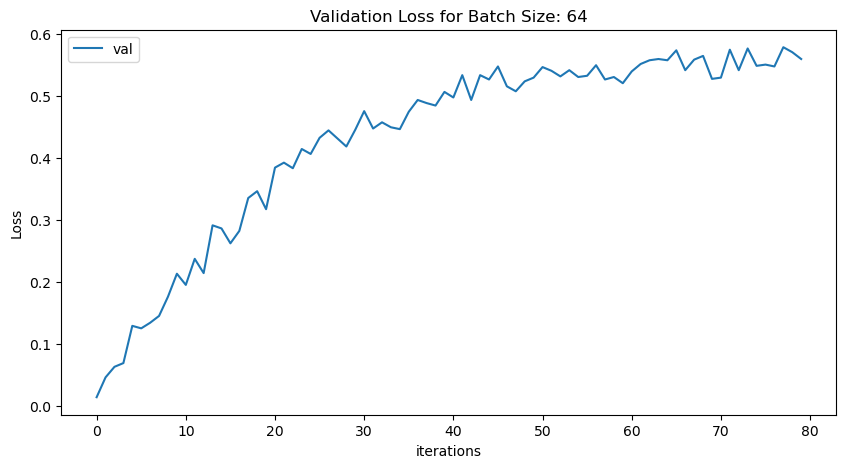

In [5]:
################################################################################
# TODO:                                                                        #         
# Experiment with any architectures, optimizers, and hyperparameters.          #
# Achieve AT LEAST 52% accuracy on the *validation set* within 10 epochs.      #
#                                                                              #
# Note that you can use the check_accuracy function to evaluate on either      #
# the test set or the validation set, by passing either loader_test or         #
# loader_val as the second argument to check_accuracy. You should not touch    #
# the test set until you have finished your architecture and  hyperparameter   #
# tuning, and only run the test set once at the end to report a final value.   #
################################################################################
from matplotlib import pyplot as plt
device = torch.device('cuda')
learning_rate = 1e-3
model = None
optimizer = None

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
model = GoogLeNet().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

# You should get at least 52% accuracy. 
gnet, best_model = train_part34(model, optimizer, epochs=10)

plt.figure(figsize=(10,5))
plt.title("Validation Loss for Batch Size: " + str(64))
plt.plot(gnet,label="val")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Describe what you did (10% of Grade)

In the cell below you should write an explanation of what you did, any additional features that you implemented, and/or any graphs that you made in the process of training and evaluating your network.

TODO: I implemented the GoogLeNet, which uses Inception blocks incorporated with 1x1 convoutions to reduce dimensionality, thus reducing computational needs, along with average pooling, in my case using adaptive average pooling to simplify implementation, which decreases the number of trainable parameters to improve accuracy even further. I created a separate class for the Inception block, which consists of concatenated 1x1 convolution, 3x3 convolution, 5x5 convolution and a 3x3 max pooling layers, all respectively stacked with a 1x1 convolution, excluding obviously the first 1x1 convolution. All of the channel sizes, kernel sizes, pool proj and stride values were taken directly from the GoogLeNet paper's picture of the architecture, and the initial convolutional layer for the feature map was separately designed for the Cifar-100 dataset as its image size is different from the ImageNet dataset originally used to train in the paper. Even without the use of residual blocks, this architecture was able to reach an accuracy well above 50%. The other hyperparameters were played around with, but best performance was given with the original set, so I ended up using Adam optimizer, 1e-3 learning rate and 64 batch size.

## Test set -- run this only once

Now that we've gotten a result we're happy with, we test our final model on the test set (which you should store in best_model). Think about how this compares to your validation set accuracy.

In [6]:
# best_model = model
check_accuracy_part34(loader_test, best_model)

Checking accuracy on test set
Got 5766 / 10000 correct (57.66)


0.5766

The test accuracy is relatively close to the validation accuracy, which suggests a well trained model that reflects the training process well.